#GENA-LM on integrative data

## Imports and functions

In [ ]:
from IPython.display import clear_output

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
clear_output()

In [ ]:
!pip uninstall -y transformers accelerate
!pip install transformers accelerate
!pip install datasets
!pip install transformers
!pip install wandb
!pip install tqdm
clear_output()

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, balanced_accuracy_score, roc_auc_score, matthews_corrcoef
import datasets
from transformers import AutoTokenizer, BigBirdForSequenceClassification, AutoModelForSequenceClassification, AutoModel
import torch
import transformers
from torch.nn import BCEWithLogitsLoss
from transformers import BigBirdTokenizer, BigBirdForSequenceClassification, EvalPrediction, AutoTokenizer
from transformers import TrainingArguments
from transformers import Trainer
from torch.utils.data import Dataset, DataLoader
import wandb
import random
from tqdm import tqdm
clear_output()

In [ ]:
import torch.nn as nn

In [ ]:
class HARData(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
def tokenization(batched_text):
    return tokenizer(batched_text['text'], padding = 'max_length', truncation=True, max_length = 4096)

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # argmax(pred.predictions, axis=1)
    #pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)
    acc = balanced_accuracy_score(labels, preds)
    auc = roc_auc_score(labels, preds)
    mcc = matthews_corrcoef(labels, preds)
    return {
        'balanced_accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'auc': auc,
        'mcc': mcc
    }

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('AIRI-Institute/gena-lm-bigbird-base-t2t')
model = BigBirdForSequenceClassification.from_pretrained('AIRI-Institute/gena-lm-bigbird-base-t2t')
clear_output()

In [ ]:
model

BigBirdForSequenceClassification(
  (bert): BigBirdModel(
    (embeddings): BigBirdEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=3)
      (position_embeddings): Embedding(4096, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BigBirdEncoder(
      (layer): ModuleList(
        (0-11): 12 x BigBirdLayer(
          (attention): BigBirdAttention(
            (self): BigBirdBlockSparseAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): BigBirdSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [ ]:
for i, layer in enumerate(model.children()):
  if i < 1:
    for param in layer.parameters():
      param.requires_grad = False

In [ ]:
from IPython.display import clear_output
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

class ProgressPlotter:
  def __init__(self,title = None) -> None:
    self._history_dict = defaultdict(list)
    self.title = title

  def add_scalar(self, tag: str, value)-> None:
    self._history_dict[tag].append(value)

  def display_keys(self,ax,tags):
    if isinstance(tags, str):
      tags = [tags]
    history_len = 0
    ax.grid()
    for key in tags:
      ax.plot(self._history_dict[key], marker="X",label=key)
      history_len = max(history_len,len(self.history_dict[key]))
    if len(tags) > 1:
      ax.legend(loc="lower left")
    else:
      ax.set_ylabel(key)
    ax.set_xlabel('step')
    ax.set_xticks(np.arange(history_len))
    ax.set_xticklabels(np.arange(history_len))

  """
     groups list of keys like [['loss_train','loss_val'],['accuracy']]
     All charts within a group will be plot in the same axis
  """
  def display(self,groups = None):
    clear_output()
    if groups is None:
      groups = self._history_dict.keys()
    n_groups = len(groups)
    fig, ax = plt.subplots(n_groups, 1, figsize=(12, 3*n_groups))
    fig.suptitle(self.title)
    if n_groups == 1:
      ax = [ax]
    for i, keys in enumerate(groups):
      self.display_keys(ax[i],keys)
    fig.tight_layout()
    plt.show()

  @property
  def history_dict(self):
    return dict(self._history_dict)

In [ ]:
@torch.inference_mode()
def get_correct_count(pred,labels):
  _, predicted = torch.max(pred.data, 1)
  return (predicted == labels).sum().item()

@torch.inference_mode()
def calaculate_accuracy(model, data_loader, criterion ):
    correct, total = 0, 0
    loss = 0
    for batch in data_loader:
        imgs, labels = batch
        pred = model(imgs)
        loss += criterion(pred, labels)
        correct += get_correct_count(pred,labels)
        total += labels.size(0)

    return correct / total , loss.item() / len(data_loader)

In [ ]:
def train(model, criterion, optimizer, num_epochs=10):
    pp = ProgressPlotter()
    for epoch in range(num_epochs):
        correct, total, ep_loss = 0, 0, 0
        for ex, labels in train_loader:
            ex, labels = ex.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(ex)
            print(outputs)
            print(labels)
            loss = criterion(outputs, labels[0])
            correct += get_correct_count(outputs,labels)
            loss.backward()
            optimizer.step()
            total += labels.size(0)
            ep_loss += loss.item()
        # Logging
        pp.add_scalar('loss_train', ep_loss / len(train_loader))
        pp.add_scalar('accuracy_train', correct/total)

        accuracy, loss_val = calaculate_accuracy(model,test_loader,criterion)
        pp.add_scalar('loss_val',loss_val)
        pp.add_scalar('accuracy_val',accuracy)

        pp.display([['loss_train','loss_val'],['accuracy_train','accuracy_val']])
    return pp

##Prepare data

Reading data

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/neural_networks/data/integrative/integrative.csv')

In [ ]:
data = dataset.sample(frac=1)

Train-test split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

train_text_df = pd.DataFrame({'text': train_data['sequence'], 'label': train_data['SE_presence']})
test_text_df = pd.DataFrame({'text': test_data['sequence'], 'label': test_data['SE_presence']})
train_text_df = train_text_df.reset_index(drop=True)
test_text_df = test_text_df.reset_index(drop=True)

train_dataset = datasets.Dataset.from_pandas(train_text_df)
test_dataset = datasets.Dataset.from_pandas(test_text_df)

In [ ]:
train_dataset = train_dataset.map(tokenization, batched = True, batch_size = len(train_dataset))
test_dataset = test_dataset.map(tokenization, batched = True, batch_size = len(test_dataset))

train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

## Fine-tuning of classifier

In [ ]:
# define the training arguments
training_args = TrainingArguments(
    output_dir = '/content/drive/MyDrive/SE_annotation_project/integrative/results',
    num_train_epochs = 5,
    per_device_train_batch_size = 2,
    gradient_accumulation_steps = 32,
    per_device_eval_batch_size= 16,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    disable_tqdm = False,
    load_best_model_at_end=True,
    warmup_steps=160,
    weight_decay=0.01,
    logging_steps = 5,
    learning_rate = 1e-4,
    fp16 = True,
    logging_dir='./log',
    dataloader_num_workers = 0,
    run_name = 'bigbird_classification_classificator'
)

In [ ]:
# instantiate the trainer class and check for available devices
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
trainer.train()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Balanced Accuracy,F1,Precision,Recall,Auc,Mcc
0,0.694800,0.691859,0.502110,0.367075,0.751230,0.528000,0.502110,0.047158
1,0.692900,0.690375,0.547665,0.468818,0.680443,0.570000,0.547665,0.189081
2,0.688000,0.687659,0.545298,0.497086,0.592720,0.564000,0.545298,0.131160
4,0.691400,0.688784,0.516902,0.346559,0.706943,0.492000,0.516902,0.115070


TrainOutput(global_step=155, training_loss=0.6908202632780998, metrics={'train_runtime': 2618.1936, 'train_samples_per_second': 3.819, 'train_steps_per_second': 0.059, 'total_flos': 2.102447609217024e+16, 'train_loss': 0.6908202632780998, 'epoch': 4.96})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.6850107312202454,
 'eval_balanced_accuracy': 0.6232131684073736,
 'eval_f1': 0.6248982756466828,
 'eval_precision': 0.6252493506493506,
 'eval_recall': 0.626,
 'eval_auc': 0.6232131684073735,
 'eval_mcc': 0.24788418082213115,
 'eval_runtime': 101.9115,
 'eval_samples_per_second': 4.906,
 'eval_steps_per_second': 0.314,
 'epoch': 4.96}

In [ ]:
# save the best model
trainer.model.save_pretrained('/content/drive/MyDrive/SE_annotation_project/integrative/results/bigbird_base')
tokenizer.save_pretrained('/content/drive/MyDrive/SE_annotation_project/integrative/results/bigbird_base')

('/content/drive/MyDrive/SE_annotation_project/integrative/results/bigbird_base/tokenizer_config.json',
 '/content/drive/MyDrive/SE_annotation_project/integrative/results/bigbird_base/special_tokens_map.json',
 '/content/drive/MyDrive/SE_annotation_project/integrative/results/bigbird_base/tokenizer.json')

In [ ]:
history =  trainer.state.log_history

In [ ]:
epoch = []
epoch_metrics = []
training_loss = []
eval_loss = []
balanced_accuracy = []
f1 = []
precision = []
recall = []
roc_auc = []
mcc = []

for d in history:
  if 'loss' in d:
    epoch.append(d['epoch'])
    training_loss.append(d['loss'])
  if 'eval_loss' in d:
    epoch_metrics.append(d['epoch'])
    balanced_accuracy.append(d['eval_balanced_accuracy'])
    f1.append(d['eval_f1'])
    precision.append(d['eval_precision'])
    recall.append(d['eval_recall'])
    roc_auc.append(d['eval_auc'])
    mcc.append(d['eval_mcc'])
    eval_loss.append(d['eval_loss'])

In [ ]:
eval_metrics_list = [f1, precision, recall, roc_auc, mcc]

In [ ]:
epoch_train = []
train_loss =[]
idx = [0, 0, 0, 0, 0]
for i in range(len(epoch)):
  for j in range(5):
    if abs(j+1-epoch[i]) < abs(j+1-epoch[idx[j]]):
      idx[j] = i
#print(epoch)
#print(len(epoch))
#print(idx)
for i in idx:
  epoch_train.append(epoch[i])
  train_loss.append(training_loss[i])

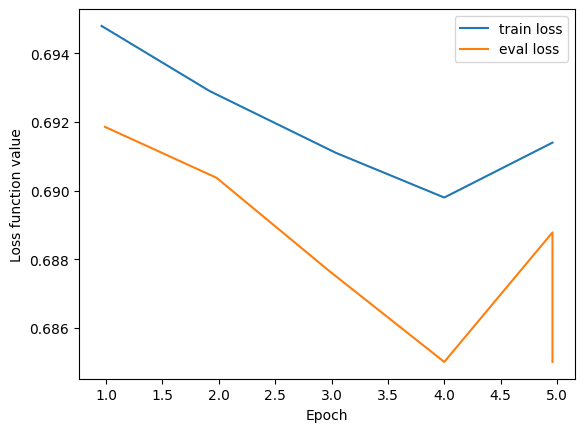

In [ ]:
import matplotlib.pyplot as plt
plt.plot(epoch_train, train_loss, label = 'train loss')
plt.plot(epoch_metrics, eval_loss, label = 'eval loss')
plt.xlabel('Epoch')
plt.ylabel('Loss function value')
plt.legend()

Text(0, 0.5, 'Balanced accuracy')

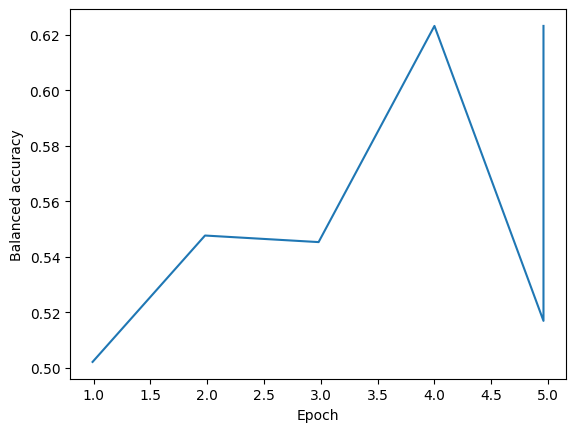

In [ ]:
plt.plot(epoch_metrics, balanced_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Balanced accuracy')

Text(0, 0.5, 'Metric')

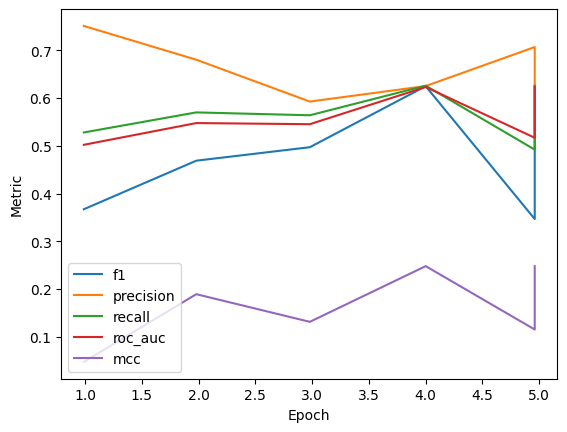

In [ ]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

for i in eval_metrics_list:
  plt.plot(epoch_metrics, i, label = namestr(i, globals())[1])
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Metric')

## Fine-tuning of the full model

In [ ]:
from transformers import AutoTokenizer, BigBirdForSequenceClassification, AutoModelForSequenceClassification, AutoModel

tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/SE_annotation_project/integrative/results/bigbird_base')
model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/SE_annotation_project/integrative/results/bigbird_base')

In [ ]:
for i, layer in enumerate(model.children()):
  for param in layer.parameters():
    param.requires_grad = True

In [ ]:
# define the training arguments
training_args = TrainingArguments(
    output_dir = '/content/drive/MyDrive/SE_annotation_project/integrative/results_bert',
    num_train_epochs = 5,
    per_device_train_batch_size = 1,
    gradient_accumulation_steps = 32,
    per_device_eval_batch_size= 1,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    disable_tqdm = False,
    load_best_model_at_end=True,
    warmup_steps=160,
    weight_decay=0.01,
    logging_steps = 5,
    learning_rate = 1e-5,
    fp16 = True,
    logging_dir='./log_bert',
    dataloader_num_workers = 0,
    run_name = 'bigbird_classification_bert'
)

In [ ]:
trainer2 = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
trainer2.train()

Epoch,Training Loss,Validation Loss,Balanced Accuracy,F1,Precision,Recall,Auc,Mcc
0,0.677200,0.671141,0.617389,0.602965,0.629566,0.610000,0.617389,0.243647
2,0.635800,0.633619,0.659656,0.654909,0.664105,0.656000,0.659656,0.321360
4,0.522800,0.619857,0.654859,0.655923,0.655866,0.656000,0.654859,0.309857


TrainOutput(global_step=310, training_loss=0.6403966472994896, metrics={'train_runtime': 9806.2475, 'train_samples_per_second': 1.02, 'train_steps_per_second': 0.032, 'total_flos': 2.102447609217024e+16, 'train_loss': 0.6403966472994896, 'epoch': 4.96})

In [ ]:
trainer2.evaluate()

{'eval_loss': 0.6198570728302002,
 'eval_balanced_accuracy': 0.6548587380276267,
 'eval_f1': 0.6559227015921931,
 'eval_precision': 0.6558663990365314,
 'eval_recall': 0.656,
 'eval_auc': 0.6548587380276267,
 'eval_mcc': 0.30985669950991684,
 'eval_runtime': 104.7792,
 'eval_samples_per_second': 4.772,
 'eval_steps_per_second': 4.772,
 'epoch': 4.96}

In [ ]:
trainer2.model.save_pretrained('/content/drive/MyDrive/SE_annotation_project/integrative/results_bert/bigbird_base')
tokenizer.save_pretrained('/content/drive/MyDrive/SE_annotation_project/integrative/results_bert/bigbird_base')

('/content/drive/MyDrive/SE_annotation_project/integrative/results_bert/bigbird_base/tokenizer_config.json',
 '/content/drive/MyDrive/SE_annotation_project/integrative/results_bert/bigbird_base/special_tokens_map.json',
 '/content/drive/MyDrive/SE_annotation_project/integrative/results_bert/bigbird_base/tokenizer.json')

In [ ]:
history2 =  trainer2.state.log_history

for d in history2:
  if 'loss' in d:
    epoch.append(d['epoch']+5)
    training_loss.append(d['loss'])
  if 'eval_loss' in d:
    epoch_metrics.append(d['epoch']+5)
    balanced_accuracy.append(d['eval_balanced_accuracy'])
    f1.append(d['eval_f1'])
    precision.append(d['eval_precision'])
    recall.append(d['eval_recall'])
    roc_auc.append(d['eval_auc'])
    mcc.append(d['eval_mcc'])
    eval_loss.append(d['eval_loss'])

In [ ]:
eval_metrics_list = [f1, precision, recall, roc_auc, mcc]

epoch_train = []
train_loss =[]
idx = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
for i in range(len(epoch)):
  for j in range(10):
    if abs(j+1-epoch[i]) < abs(j+1-epoch[idx[j]]):
      idx[j] = i
for i in idx:
  epoch_train.append(epoch[i])
  train_loss.append(training_loss[i])

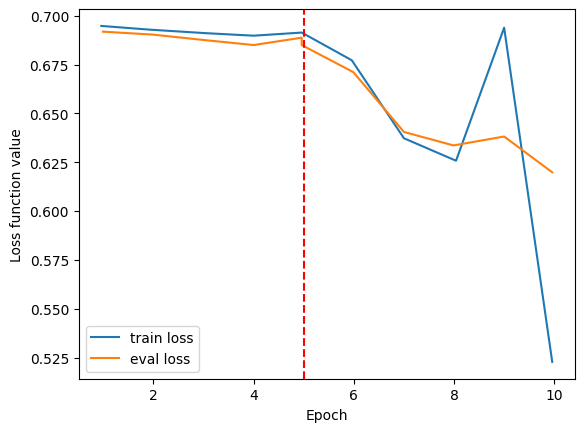

In [ ]:
import matplotlib.pyplot as plt
plt.plot(epoch_train, train_loss, label = 'train loss')
plt.plot(epoch_metrics, eval_loss, label = 'eval loss')
plt.xlabel('Epoch')
plt.ylabel('Loss function value')
plt.legend()
plt.axvline(x=5, linestyle = '--', color = 'red')

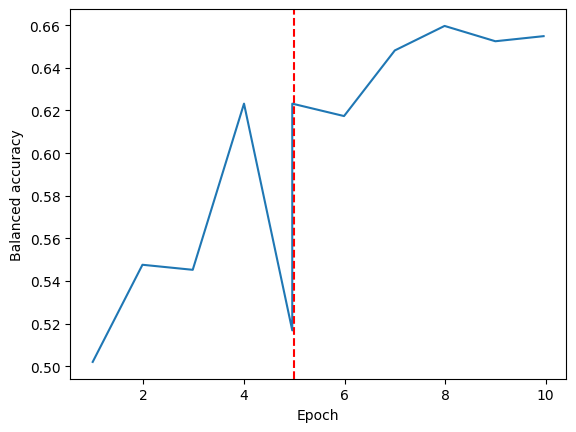

In [ ]:
plt.plot(epoch_metrics, balanced_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Balanced accuracy')
plt.axvline(x=5, linestyle = '--', color = 'red')

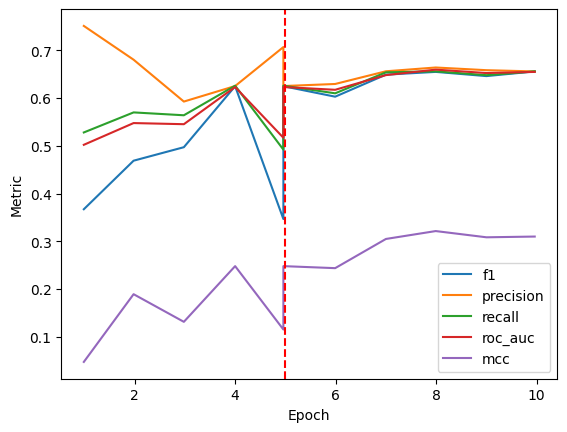

In [ ]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

for i in eval_metrics_list:
  plt.plot(epoch_metrics, i, label = namestr(i, globals())[1])
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.axvline(x=5, linestyle = '--', color = 'red')

## Fine-tuning of the full model (part 2)

In [ ]:
from transformers import AutoTokenizer, BigBirdForSequenceClassification, AutoModelForSequenceClassification, AutoModel

tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/SE_annotation_project/integrative/results_bert/bigbird_base')
model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/SE_annotation_project/integrative/results_bert/bigbird_base')

In [ ]:
for i, layer in enumerate(model.children()):
  for param in layer.parameters():
    param.requires_grad = True

In [ ]:
trainer3 = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
trainer3.train()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Balanced Accuracy,F1,Precision,Recall,Auc,Mcc
0,0.550400,0.560184,0.710839,0.704904,0.717585,0.706000,0.710839,0.424866
2,0.634700,0.533804,0.739623,0.735679,0.743927,0.736000,0.739623,0.480419
4,0.387200,0.552062,0.741389,0.743364,0.743904,0.744000,0.741389,0.485184


TrainOutput(global_step=310, training_loss=0.5330774537978634, metrics={'train_runtime': 9791.0687, 'train_samples_per_second': 1.021, 'train_steps_per_second': 0.032, 'total_flos': 2.102447609217024e+16, 'train_loss': 0.5330774537978634, 'epoch': 4.96})

In [ ]:
trainer3.evaluate()

In [ ]:
trainer3.model.save_pretrained('/content/drive/MyDrive/SE_annotation_project/integrative/results_bert_2/bigbird_base')
tokenizer.save_pretrained('/content/drive/MyDrive/SE_annotation_project/integrative/results_bert_2/bigbird_base')

In [ ]:
history3 =  trainer3.state.log_history

for d in history3:
  if 'loss' in d:
    epoch.append(d['epoch']+10)
    training_loss.append(d['loss'])
  if 'eval_loss' in d:
    epoch_metrics.append(d['epoch']+10)
    balanced_accuracy.append(d['eval_balanced_accuracy'])
    f1.append(d['eval_f1'])
    precision.append(d['eval_precision'])
    recall.append(d['eval_recall'])
    roc_auc.append(d['eval_auc'])
    mcc.append(d['eval_mcc'])
    eval_loss.append(d['eval_loss'])

In [ ]:
eval_metrics_list = [f1, precision, recall, roc_auc, mcc]

epoch_train = []
train_loss =[]
idx = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
for i in range(len(epoch)):
  for j in range(15):
    if abs(j+1-epoch[i]) < abs(j+1-epoch[idx[j]]):
      idx[j] = i
for i in idx:
  epoch_train.append(epoch[i])
  train_loss.append(training_loss[i])

In [ ]:
plt.plot(epoch_train, train_loss, label = 'train loss')
plt.plot(epoch_metrics, eval_loss, label = 'eval loss')
plt.xlabel('Epoch')
plt.ylabel('Loss function value')
plt.legend()
plt.axvline(x=5, linestyle = '--', color = 'red')

In [ ]:
plt.plot(epoch_metrics, balanced_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Balanced accuracy')
plt.axvline(x=5, linestyle = '--', color = 'red')

In [ ]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

for i in eval_metrics_list:
  plt.plot(epoch_metrics, i, label = namestr(i, globals())[1])
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.axvline(x=5, linestyle = '--', color = 'red')

### max_metrics

In [ ]:
print(eval_loss)

In [ ]:
print(max(balanced_accuracy))

In [ ]:
print(max(f1))

In [ ]:
print(max(roc_auc))

In [ ]:
print(max(precision))

In [ ]:
print(max(recall))

In [ ]:
print(max(mcc))

## t-SNE

In [ ]:
from transformers import AutoTokenizer, BigBirdForSequenceClassification, AutoModelForSequenceClassification, AutoModel

tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/SE_annotation_project/integrative/results_bert_2/bigbird_base')
model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/SE_annotation_project/integrative/results_bert_2/bigbird_base')

In [ ]:
for i, layer in enumerate(model.children()):
  for param in layer.parameters():
    param.requires_grad = False

In [ ]:
encoder = model.bert

In [ ]:
def predict(inputs):
    return model(inputs)[0]

def construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id):

    text_ids = tokenizer.encode(text, add_special_tokens=False)
    # construct input token ids
    input_ids = [cls_token_id] + text_ids + [sep_token_id]
    # construct reference token ids
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(text_ids)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
encoder.to(device)

BigBirdModel(
  (embeddings): BigBirdEmbeddings(
    (word_embeddings): Embedding(32000, 768, padding_idx=3)
    (position_embeddings): Embedding(4096, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BigBirdEncoder(
    (layer): ModuleList(
      (0-11): 12 x BigBirdLayer(
        (attention): BigBirdAttention(
          (self): BigBirdBlockSparseAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
          )
          (output): BigBirdSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
    

In [ ]:
ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

In [ ]:
from tqdm import tqdm
df = pd.concat([test_text_df, test_text_df, train_text_df])
tokens = []
for i in df['text']:
  tokens.append(len(tokenizer.tokenize(i)))
df['tl'] = np.array(tokens)

In [ ]:
df.shape

(3000, 3)

In [ ]:
df = df[df['tl']<= 4096]

In [ ]:
df.shape

(2997, 3)

In [ ]:
mat = []
for i in tqdm(df['text']):
  input_ids, ref_input_ids, sep_id = construct_input_ref_pair(i, ref_token_id, sep_token_id, cls_token_id)
  #encoder(input_ids.to(device)).pooler_output[0]
  mat.append(encoder(input_ids.to(device)).pooler_output[0])

  0%|          | 1/2997 [00:01<1:15:56,  1.52s/it]Input ids are automatically padded from 986 to 1024 to be a multiple of `config.block_size`: 64
Input ids are automatically padded from 2554 to 2560 to be a multiple of `config.block_size`: 64
  0%|          | 10/2997 [00:03<12:13,  4.07it/s]Input ids are automatically padded from 890 to 896 to be a multiple of `config.block_size`: 64
Input ids are automatically padded from 3324 to 3328 to be a multiple of `config.block_size`: 64
100%|██████████| 2997/2997 [22:58<00:00,  2.17it/s]


In [ ]:
labels = np.array(df.label)

In [ ]:
mat_2 = []
for i in mat:
  mat_2.append(np.array(i.cpu()))

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2) #n_components means the lower dimension
low_dim_data = tsne.fit_transform(np.array(mat_2))

In [ ]:
import seaborn as sns
# Style Plots a bit
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1,rc={"lines.linewidth": 2.5})

%matplotlib inline
import matplotlib as plt
plt.rcParams['figure.figsize'] = (20, 14)
import matplotlib.pyplot as plt1

Text(0.5, 1.0, 'T-SNE BERT Embeddings, colored by class')

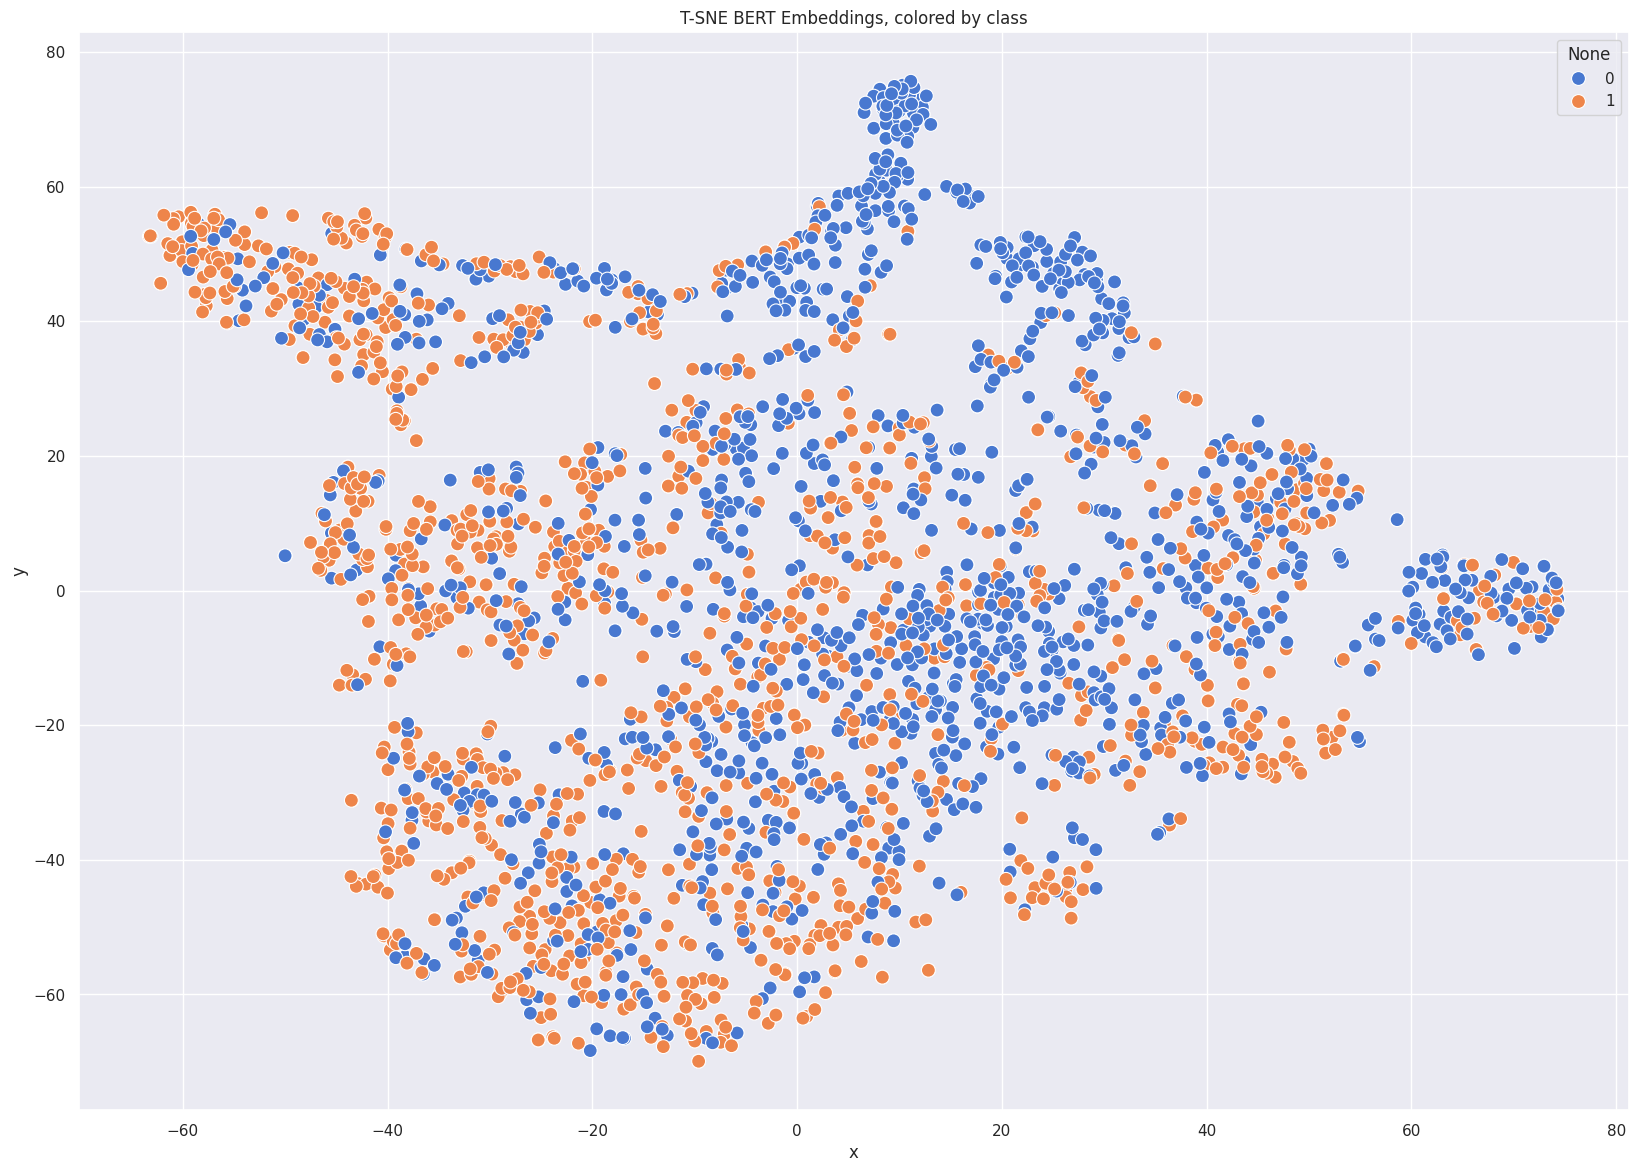

In [ ]:
tsne_df =  pd.DataFrame(low_dim_data, labels)
tsne_df.columns = ['x','y']
ax = sns.scatterplot(data=tsne_df, x='x', y='y', hue=tsne_df.index, s = 100)
ax.set_title('T-SNE BERT Embeddings, colored by class')

## UMAP

In [ ]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.0 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=21eae825e706821538a0317a41a9f9956183b59910fcffabd404457bffb25148
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [ ]:
import umap.umap_ as umap

In [ ]:
reducer = umap.UMAP(random_state=42)

umap = reducer.fit_transform(np.array(mat_2))
clear_output()

Text(0.5, 1.0, 'UMAP BERT Embeddings, colored by class')

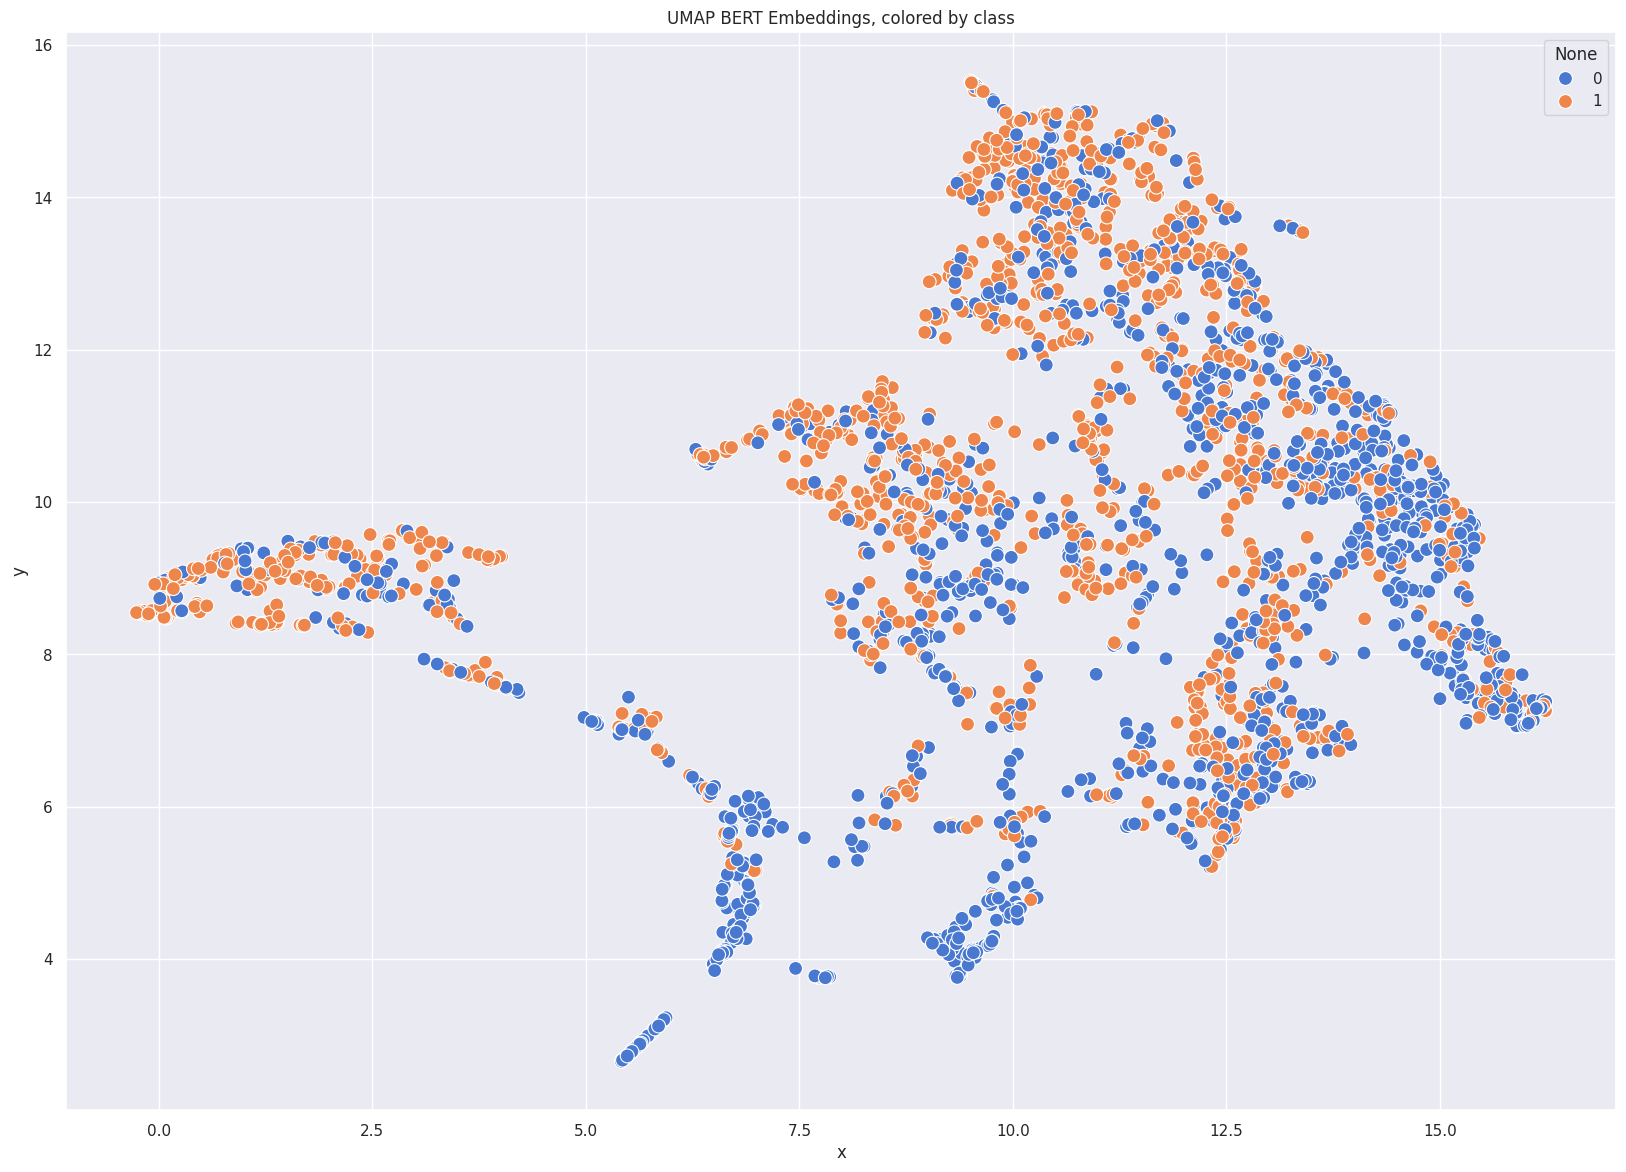

In [ ]:
umap_df =  pd.DataFrame(umap, labels)
umap_df.columns = ['x','y']
ax = sns.scatterplot(data=umap_df, x='x', y='y', hue=umap_df.index, s = 100)
ax.set_title('UMAP BERT Embeddings, colored by class')